In [1]:
! pip install --quiet pymongo[srv,tls] 
! pip install --quiet pystan

In [55]:
from pymongo import MongoClient
from dateutil.parser import parse
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import mannwhitneyu
import os

In [6]:
client = MongoClient(os.environ.get('MONGO_HOST'), 
         
            username = os.environ.get('MONGO_USER'), 
                     password = os.environ.get('MONGO_PASS'))
coll = client['mab-survey'].trial

In [25]:
def get_avg_interval(boxes):
    times = [parse(b['timestamp']) for b in boxes]
    return np.mean(np.diff(times)).seconds
    

def get_spread(d): 
    boxes = d['boxes'][1]
    return parse(boxes[-1]['timestamp']) - parse(boxes[0]['timestamp'])

won = lambda b: len([i for i in b if i['result'] == 'win']) > 0

16

In [151]:
from scipy.stats import beta

l = list(coll.find({ 'version': '0.5'}))
w = [won(i['boxes'][1]) for i in l]
t = [i['treatment']['ab'] for i in l]
time = [get_spread(d).total_seconds() for d in l]
rolls = [len(d['boxes'][1]) for d in l]
avg = [get_avg_interval(i['boxes'][1]) for i in l]

df = pd.DataFrame({
    'won': w,
    'treatment': t,
    'time': time,
    'rolls': rolls,
    'roll_time': avg
})


posterior = lambda n: beta.mean(1,1 + n)

# opportunity cost per second
df['opportunity_cost'] = df.rolls.map(posterior) * 5/df.roll_time

(_,a),(_,b) = df[df.won == False].groupby('treatment')

In [128]:
from pystan import StanModel

model = StanModel('../experiments/distortion.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d5e3cc9ebc02a19bd06a406b660e96df NOW.


In [165]:
df = df.assign(group = (df.treatment == 'a').astype(int) + 1)
df = df.assign(t = df.treatment.map(lambda t: 1/40 if t == 'b' else 1/160 ))
df = df.assign(roll_cost = df.roll_time / 5 )
d = df[df.won == False]
d.to_csv('distortion.csv')

data = {
    'M': d.shape[0],
    'N': d.rolls.tolist(),
    'roll_cost': d.roll_cost.tolist(),
}


In [ ]:
model.vb(data)

In [ ]:
df[df.won == False].opportunity_cost * 60 * 60

In [153]:
df[df.won == False].groupby('treatment').median()

           roll_time  rolls     time    won  opportunity_cost
treatment                                                    
a                  4     54  239.907  False          0.021368
b                 15     18  311.389  False          0.014448

In [154]:
df[df.won == False].groupby('treatment').mean()

           roll_time      rolls        time    won  opportunity_cost
treatment                                                           
a           4.517241  76.724138  374.412828  False          0.036450
b          16.892857  23.714286  400.077000  False          0.020875

In [155]:
mannwhitneyu(a.time.tolist(), b.time.tolist())

MannwhitneyuResult(statistic=370.0, pvalue=0.28547064710934872)

In [156]:
mannwhitneyu(a.opportunity_cost.tolist(), b.opportunity_cost.tolist())

MannwhitneyuResult(statistic=317.5, pvalue=0.080049587162322633)

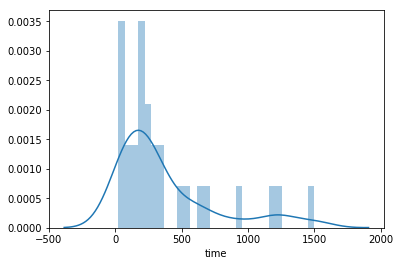

In [157]:
sns.distplot(a.time, bins=30)

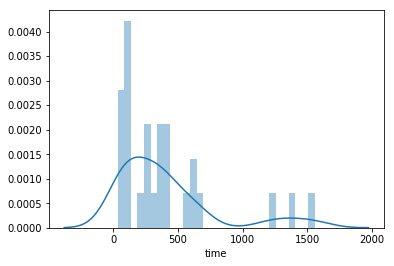

In [158]:
sns.distplot(b.time, bins=30)

[(0, 0.15)]

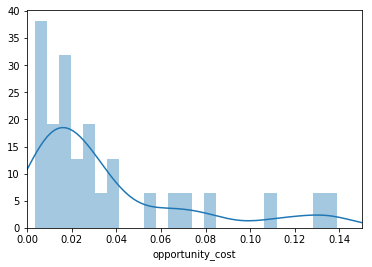

In [161]:
sns.distplot(a.opportunity_cost, bins = 25).set(xlim=(0,.15))

[(0, 0.15)]

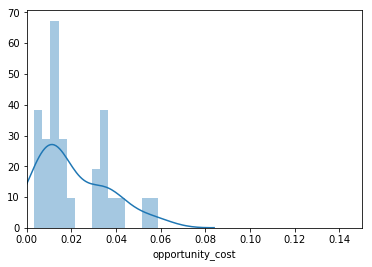

In [162]:
sns.distplot(b.opportunity_cost, bins = 15).set(xlim=(0,.15))